In [1]:
# Notebook 3: Interaktive Karte mit Satellitendaten-Overlay
# Dieses Notebook zeigt, wie man Satellitenbilder auf einer interaktiven Karte darstellt.

# 1. Benötigte Bibliotheken importieren
# ---
import folium
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import os
import glob # This was missing in your code


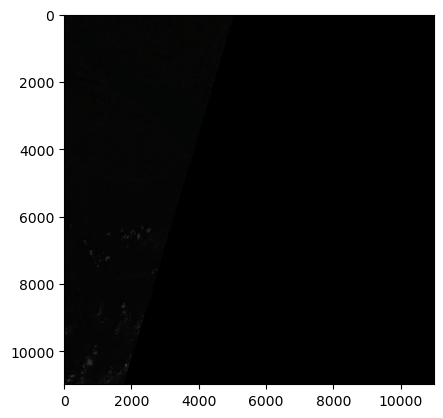

Interaktive Karte in interaktive_sat_karte.html gespeichert. Öffne sie im Browser!


In [2]:

# ---
# 2. Pfade definieren und Sentinel-2 Daten verarbeiten
# ---

# Passe diesen Pfad an den Speicherort deines Sentinel-2 .SAFE-Ordners an.
# Der '~/'-Teil in deinem Pfad ist für Python nicht direkt nutzbar.
# Hier wird er durch den vollen Pfad ersetzt.
sentinel_data_dir = 'S2B_MSIL2A_20250702T102559_N0511_R108_T32TNT_20250702T124602.SAFE'

# Überprüfe, ob der Pfad existiert
if not os.path.isdir(sentinel_data_dir):
    print(f"Fehler: Das Sentinel-2 Verzeichnis wurde nicht gefunden: {sentinel_data_dir}")
else:
    try:
        # Finde den Pfad zum IMG_DATA-Ordner
        img_data_path = glob.glob(os.path.join(sentinel_data_dir, 'GRANULE', '*', 'IMG_DATA'))
        if not img_data_path:
            raise FileNotFoundError("IMG_DATA-Verzeichnis nicht gefunden. Überprüfe die Ordnerstruktur.")

        img_data_path = img_data_path[0]


        # Finde die Pfade zu den einzelnen Bändern (B04, B03, B02)
        band_4_path = glob.glob(os.path.join(img_data_path, 'R10m', '*_B04_10m.jp2'))[0]
        band_3_path = glob.glob(os.path.join(img_data_path, 'R10m', '*_B03_10m.jp2'))[0]
        band_2_path = glob.glob(os.path.join(img_data_path, 'R10m', '*_B02_10m.jp2'))[0]

        # Lese die Bänder ein und erstelle ein RGB-Komposit
        with rasterio.open(band_4_path) as r, \
             rasterio.open(band_3_path) as g, \
             rasterio.open(band_2_path) as b:

            if r.shape != g.shape or r.shape != b.shape:
                raise ValueError("Die Bänder haben unterschiedliche Dimensionen.")

            # Lese die Bänder ein
            red = r.read(1)
            green = g.read(1)
            blue = b.read(1)

            # Staple die Bänder zu einem RGB-Array
            rgb_composite = np.stack([red, green, blue], axis=-1)

            # Normalisiere die Daten auf den 0-255 Bereich
            rgb_composite_8bit = (rgb_composite / np.iinfo(rgb_composite.dtype).max * 255).astype(np.uint8)

            # show image

            plt.imshow(rgb_composite_8bit)
            plt.show(block=True)


            # Hole die geografischen Grenzen des Bildes
            bounds = [[r.bounds.bottom, r.bounds.left], [r.bounds.top, r.bounds.right]]

            # Bestimme das Zentrum der Karte basierend auf den Bildgrenzen
            map_center = [r.bounds.top - (r.bounds.top - r.bounds.bottom) / 2,
                          r.bounds.left + (r.bounds.right - r.bounds.left) / 2]

        # ---
        # 3. Interaktive Karte erstellen und Bild-Overlay hinzufügen
        # ---
        m = folium.Map(location=map_center, zoom_start=12)

        # Füge das RGB-Bild als Raster-Overlay hinzu
        folium.raster_layers.ImageOverlay(
            image=rgb_composite_8bit,
            bounds=bounds,
            opacity=0.7,
            alt='Satellitenbild Overlay'
        ).add_to(m)

        # Füge einen Layer-Kontrollschalter hinzu, um das Bild an- und auszuschalten
        folium.LayerControl().add_to(m)

        # Speichere die interaktive Karte als HTML-Datei
        map_html_path = 'interaktive_sat_karte.html'
        m.save(map_html_path)
        print(f"Interaktive Karte in {map_html_path} gespeichert. Öffne sie im Browser!")

    except (IndexError, FileNotFoundError, ValueError) as e:
        print(f"Ein Fehler ist aufgetreten: {e}")
        print("Versuche eine leere Karte zu erstellen...")

        # Erstelle eine leere Karte als Fallback
        map_center = [47.37, 8.54] # Beispiel: Zürich
        m = folium.Map(location=map_center, zoom_start=12)
        map_html_path = 'leere_karte.html'
        m.save(map_html_path)
        print(f"Leere Karte in {map_html_path} gespeichert.")